In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
plt.style.use('seaborn-white')
# colorblind safe
plt.style.use('seaborn-colorblind')
plt.style.use('tableau-colorblind10')

# width and precision for f strings
width = 10
precision = 4

# default sizes for plots
# https://matplotlib.org/3.3.0/tutorials/introductory/customizing.html#customizing-with-matplotlibrc-files
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 16
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['lines.linewidth'] = 2

# other settings
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option("display.precision", 3)
np.set_printoptions(precision=3, suppress=True)
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_columns', None)
%config IPCompleter.greedy=True


In [2]:
import os
G_MAPS_API = os.environ.get("GOOGLE_STATICMAPS_API")

In [3]:
import random, time

In [4]:
import googlemaps

In [5]:
gmaps = googlemaps.Client(G_MAPS_API)

In [6]:
n_requests = 0

In [22]:
def download_images(client, df, zoomlevel, max_requests=10, prefix="", out_path="data/"):
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    
    global n_requests
    
    for i, site in df.iterrows():
        print(f'Pulling image {i}, total API requests so far = {n_requests}')
        #print(f"{site['Latitude']}, {site['Longitude']}")
        
        # temp save coords
        lat = site['Latitude']
        long = site['Longitude']
        
        # and tags for site
        cat = site['Category']
        
        # create filename
        cur_filename = f'satimg_{prefix}_{i}_{cat}_{zoomlevel}_{lat}_{long}.png'
        print(cur_filename)

        # if it already exists, skip to next
        if os.path.exists(out_path + cur_filename):
            continue

        # get the image
        satimg = client.static_map(size = (400, 400), # pixels
           zoom = zoomlevel, # 1-21
           center = (lat, long),
           scale = 1, # default is 1, 2 returns 2x pixels for high res displays
           maptype = "satellite",
           format = "png"
          )
        
        # if it didn't work, exit
        if satimg is None or n_requests >= max_requests:
            print("API requests quota exceeded!")    
            break
        # increase counter otherwise
        n_requests += 1
        
        # save the current image
        f = open(out_path + cur_filename, 'wb')
        for chunk in satimg:
            if chunk:
                f.write(chunk)
        f.close()
        
        # open it to crop the text off
        img = plt.imread(out_path + cur_filename)
        # maybe crop all 4 sides?
        cropped = img[25:375, 25:375]
        # and resave
        #cropped_filename = f'satimg_{i}_{cat}_{zoomlevel}_{lat}_{long}.png'
        plt.imsave(out_path + cur_filename, cropped)
        
        # and rotate and save that version
        for k, degrees in enumerate([90, 180, 270]):
            #print(k, degrees)
            cropped_rotated = np.rot90(cropped, k=k)
            cropped_rot_filename = f'satimg_{prefix}_{i}_{cat}_{zoomlevel}_{lat}_{long}_rot{degrees}.png'
            #print(cropped_rot_filename)
            plt.imsave(out_path + cropped_rot_filename, cropped_rotated)
        
        # and zoom in and save
#         zoomed = img[100:300, 100:300]
#         zoomed_cropped_filename = f'satimg_{i}_{cat}_{zoomlevel}_zoomed_{lat}_{long}.png'
#         plt.imsave(out_path + zoomed_cropped_filename, zoomed)
        
#         # and rotate on zoom in and save
#         zoomed_rot = np.rot90(zoomed)
#         zoomed_cropped_rot_filename = f'satimg_{i}_{cat}_{zoomlevel}_zoomed_rot90_{lat}_{long}.png'
#         plt.imsave(out_path + zoomed_cropped_rot_filename, zoomed_rot)
        
        # wait a bit before next request
        wait_time = random.randint(1, 5)
        print(f'waiting for: {wait_time} seconds')
        time.sleep(wait_time) # in seconds

        # display samples every now and then
        if i % 100 == 0:
            img = plt.imread(out_path + cur_filename)
            plt.imshow(img)
            plt.title(f'image {i}')
            plt.show()
            time.sleep(2)
    return True

In [7]:
USdata_cleaned = pd.read_csv('data/USdata_zip_states_combined_cleaned.csv')

In [10]:
categories = list(USdata_cleaned['Category'].unique())
categories

['Wild Camping',
 'Informal Campsite',
 'Showers',
 'Water',
 'Short-term Parking',
 'Eco-Friendly']

In [11]:
USdata_CO = USdata_cleaned[USdata_cleaned['State'] == 'CO'].copy()

In [26]:
USdata_CO.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      550 non-null    int64  
 1   Location                   109 non-null    object 
 2   Name                       550 non-null    object 
 3   Category                   550 non-null    object 
 4   Description                550 non-null    object 
 5   Latitude                   550 non-null    float64
 6   Longitude                  550 non-null    float64
 7   Altitude                   535 non-null    float64
 8   Date verified              550 non-null    object 
 9   Open                       550 non-null    object 
 10  Electricity                502 non-null    object 
 11  Wifi                       502 non-null    object 
 12  Kitchen                    502 non-null    object 
 13  Parking                    0 non-null      float64

In [16]:
USdata_CO.groupby('Category').agg('count')['Description']

Category
Eco-Friendly            6
Informal Campsite     107
Short-term Parking      1
Showers                13
Water                  28
Wild Camping          395
Name: Description, dtype: int64

In [ ]:
# maybe do this by category and put into different folders?

In [24]:
max_requests = 1000

In [17]:
out_path=f"data/sites_CO/{category}/"

In [20]:
USdata_CO = USdata_CO.reset_index()

In [21]:
USdata_CO.head()

,index,Location,Name,Category,Description,Latitude,Longitude,Altitude,Date verified,Open,Electricity,Wifi,Kitchen,Parking,Restaurant,Showers,Water,Toilets,Big rig friendly,Tent friendly,Pet friendly,Sanitation dump station,Outdoor gear,Groceries,Artesian goods,Bakery,Rarity in this area,Repairs vehicles,Repairs motorcycles,Repairs bicycles,Sells parts,Recycles batteries,Recycles oil,Bio fuel,Electric vehicle charging,Composting sawdust,Recycling center,zip_code,State
0,6,NaN,Sauls Creek,Wild Camping,National Forest Service open camping. Many pul...,37.2381,-107.5242,"2,175.0000",2018-09-08 00:00:00 UTC,Yes,No,No,No,nan,No,No,No,No,No,Yes,Yes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,81122,CO
1,21,NaN,"Lizard Head Pass Dispersed Camping, Telluride,...",Wild Camping,Next to the Lizard Head Pass with stunning vie...,37.8130,-107.9055,"3,110.5248",2020-08-19 00:00:00 UTC,Yes,No,No,No,nan,No,No,No,Pit Toilets,Yes,Yes,Yes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,81426,CO
2,94,NaN,Colorado Welcome Center,Informal Campsite,RV Parking behind Welcome Center.\nGraveled si...,40.2452,-109.0090,"1,799.1502",2019-07-25 00:00:00 UTC,Yes,No,Unknown,No,nan,No,No,No,No,Yes,Unknown,Unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,81610,CO
3,113,NaN,Walden Visitor Info Free Camp,Informal Campsite,Dirt/gravel parking lot between visitor info a...,40.7270,-106.2872,"2,442.0334",2017-10-25 00:00:00 UTC,Yes,No,No,No,nan,No,No,No,Pit Toilets,Yes,Yes,Yes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,80480,CO
4,119,NaN,Stone Quarry Road Free Camp “Take Out”,Wild Camping,A kind of dirt parking spot just between the r...,39.3952,-108.1061,"1,502.4187",2020-08-06 00:00:00 UTC,Yes,No,No,No,nan,No,No,Natural Source,No,No,Yes,Yes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,81635,CO


Wild Camping
Pulling image 0, total API requests so far = 0
satimg_CO__0_Wild Camping_17_37.238067_-107.524203.png
waiting for: 3 seconds


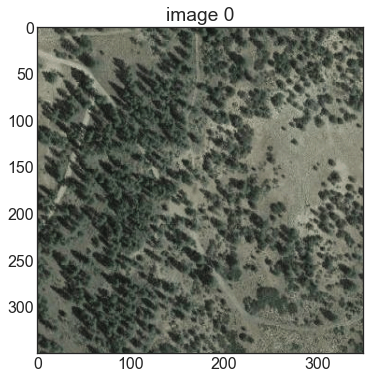

Pulling image 1, total API requests so far = 1
satimg_CO__1_Wild Camping_17_37.812975_-107.905482.png
waiting for: 5 seconds
Pulling image 4, total API requests so far = 2
satimg_CO__4_Wild Camping_17_39.39521_-108.106147.png
waiting for: 2 seconds
Pulling image 5, total API requests so far = 3
satimg_CO__5_Wild Camping_17_38.838421_-107.517971.png
waiting for: 3 seconds
Pulling image 9, total API requests so far = 4
satimg_CO__9_Wild Camping_17_39.307964_-108.702567.png
waiting for: 1 seconds
Pulling image 10, total API requests so far = 5
satimg_CO__10_Wild Camping_17_39.092332_-108.808072.png
waiting for: 4 seconds
Pulling image 11, total API requests so far = 6
satimg_CO__11_Wild Camping_17_38.776797_-108.288448.png
waiting for: 5 seconds
Pulling image 13, total API requests so far = 7
satimg_CO__13_Wild Camping_17_39.368473_-106.786083.png
waiting for: 2 seconds
Pulling image 14, total API requests so far = 8
satimg_CO__14_Wild Camping_17_40.244703_-104.05243.png
waiting for: 4 se

waiting for: 4 seconds
Pulling image 86, total API requests so far = 66
satimg_CO__86_Wild Camping_17_39.8346_-106.05345.png
waiting for: 2 seconds
Pulling image 87, total API requests so far = 67
satimg_CO__87_Wild Camping_17_39.01828_-105.18099.png
waiting for: 2 seconds
Pulling image 90, total API requests so far = 68
satimg_CO__90_Wild Camping_17_39.772194_-105.762246.png
waiting for: 5 seconds
Pulling image 93, total API requests so far = 69
satimg_CO__93_Wild Camping_17_39.100859_-106.368014.png
waiting for: 2 seconds
Pulling image 94, total API requests so far = 70
satimg_CO__94_Wild Camping_17_39.151353_-106.425406.png
waiting for: 3 seconds
Pulling image 95, total API requests so far = 71
satimg_CO__95_Wild Camping_17_40.165868_-105.457831.png
waiting for: 4 seconds
Pulling image 96, total API requests so far = 72
satimg_CO__96_Wild Camping_17_40.139004_-106.105506.png
waiting for: 4 seconds
Pulling image 97, total API requests so far = 73
satimg_CO__97_Wild Camping_17_39.2467

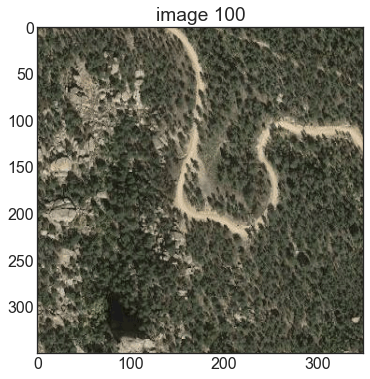

Pulling image 105, total API requests so far = 77
satimg_CO__105_Wild Camping_17_38.06261_-107.66027.png
waiting for: 3 seconds
Pulling image 106, total API requests so far = 78
satimg_CO__106_Wild Camping_17_38.53206_-102.52848.png
waiting for: 2 seconds
Pulling image 108, total API requests so far = 79
satimg_CO__108_Wild Camping_17_37.75222_-107.97693999999998.png
waiting for: 2 seconds
Pulling image 109, total API requests so far = 80
satimg_CO__109_Wild Camping_17_37.66889000000001_-108.32528.png
waiting for: 3 seconds
Pulling image 110, total API requests so far = 81
satimg_CO__110_Wild Camping_17_38.04722_-107.80917.png
waiting for: 2 seconds
Pulling image 111, total API requests so far = 82
satimg_CO__111_Wild Camping_17_38.92778_-107.27472.png
waiting for: 1 seconds
Pulling image 112, total API requests so far = 83
satimg_CO__112_Wild Camping_17_38.972505_-103.460771.png
waiting for: 5 seconds
Pulling image 113, total API requests so far = 84
satimg_CO__113_Wild Camping_17_37.

waiting for: 4 seconds
Pulling image 198, total API requests so far = 140
satimg_CO__198_Wild Camping_17_39.57495_-106.110771.png
waiting for: 2 seconds
Pulling image 199, total API requests so far = 141
satimg_CO__199_Wild Camping_17_37.720631_-107.749573.png
waiting for: 3 seconds
Pulling image 200, total API requests so far = 142
satimg_CO__200_Wild Camping_17_38.943307_-106.186081.png
waiting for: 5 seconds


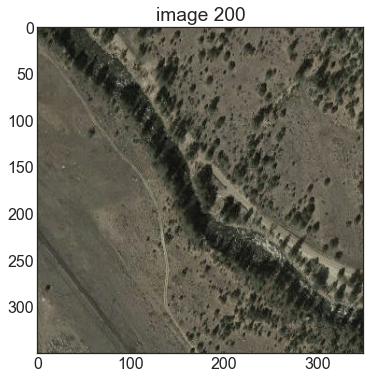

Pulling image 201, total API requests so far = 143
satimg_CO__201_Wild Camping_17_39.41959600000001_-106.272577.png
waiting for: 2 seconds
Pulling image 202, total API requests so far = 144
satimg_CO__202_Wild Camping_17_39.622652_-106.907416.png
waiting for: 2 seconds
Pulling image 205, total API requests so far = 145
satimg_CO__205_Wild Camping_17_40.124126_-105.532433.png
waiting for: 5 seconds
Pulling image 206, total API requests so far = 146
satimg_CO__206_Wild Camping_17_39.350404_-106.585145.png
waiting for: 2 seconds
Pulling image 208, total API requests so far = 147
satimg_CO__208_Wild Camping_17_39.513834_-106.428997.png
waiting for: 1 seconds
Pulling image 211, total API requests so far = 148
satimg_CO__211_Wild Camping_17_39.32121_-105.251605.png
waiting for: 4 seconds
Pulling image 212, total API requests so far = 149
satimg_CO__212_Wild Camping_17_37.394388_-108.06817.png
waiting for: 3 seconds
Pulling image 213, total API requests so far = 150
satimg_CO__213_Wild Campin

waiting for: 3 seconds
Pulling image 282, total API requests so far = 206
satimg_CO__282_Wild Camping_17_38.49635900000001_-105.028626.png
waiting for: 5 seconds
Pulling image 283, total API requests so far = 207
satimg_CO__283_Wild Camping_17_39.822497_-108.828981.png
waiting for: 3 seconds
Pulling image 284, total API requests so far = 208
satimg_CO__284_Wild Camping_17_37.800821_-107.577759.png
waiting for: 4 seconds
Pulling image 286, total API requests so far = 209
satimg_CO__286_Wild Camping_17_40.051488_-105.735293.png
waiting for: 5 seconds
Pulling image 289, total API requests so far = 210
satimg_CO__289_Wild Camping_17_37.4998_-106.763231.png
waiting for: 5 seconds
Pulling image 291, total API requests so far = 211
satimg_CO__291_Wild Camping_17_39.566972_-107.317933.png
waiting for: 4 seconds
Pulling image 293, total API requests so far = 212
satimg_CO__293_Wild Camping_17_39.24003_-106.23385.png
waiting for: 4 seconds
Pulling image 296, total API requests so far = 213
satim

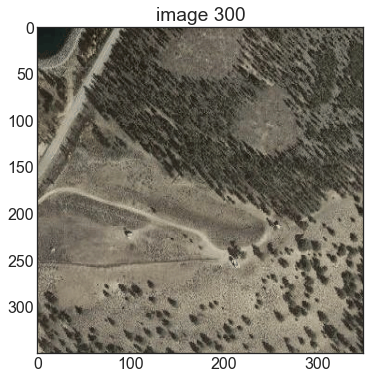

Pulling image 301, total API requests so far = 218
satimg_CO__301_Wild Camping_17_39.106134_-106.383417.png
waiting for: 4 seconds
Pulling image 304, total API requests so far = 219
satimg_CO__304_Wild Camping_17_37.59268400000001_-108.940319.png
waiting for: 2 seconds
Pulling image 305, total API requests so far = 220
satimg_CO__305_Wild Camping_17_38.375386_-108.733312.png
waiting for: 5 seconds
Pulling image 307, total API requests so far = 221
satimg_CO__307_Wild Camping_17_40.525327_-104.996499.png
waiting for: 3 seconds
Pulling image 308, total API requests so far = 222
satimg_CO__308_Wild Camping_17_39.43395_-106.05963.png
waiting for: 5 seconds
Pulling image 311, total API requests so far = 223
satimg_CO__311_Wild Camping_17_39.120114_-105.451712.png
waiting for: 2 seconds
Pulling image 317, total API requests so far = 224
satimg_CO__317_Wild Camping_17_39.672669_-104.982995.png
waiting for: 2 seconds
Pulling image 320, total API requests so far = 225
satimg_CO__320_Wild Campin

waiting for: 5 seconds
Pulling image 400, total API requests so far = 281
satimg_CO__400_Wild Camping_17_37.367449_-107.894099.png
waiting for: 4 seconds


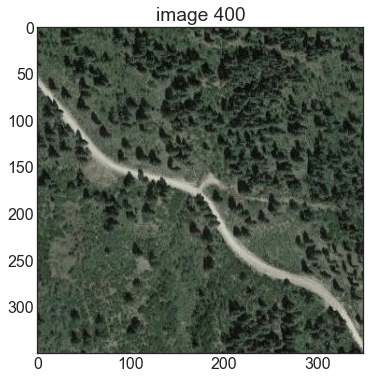

Pulling image 401, total API requests so far = 282
satimg_CO__401_Wild Camping_17_37.908767_-107.600666.png
waiting for: 4 seconds
Pulling image 402, total API requests so far = 283
satimg_CO__402_Wild Camping_17_37.25113_-105.129078.png
waiting for: 2 seconds
Pulling image 403, total API requests so far = 284
satimg_CO__403_Wild Camping_17_40.384146_-106.623231.png
waiting for: 5 seconds
Pulling image 404, total API requests so far = 285
satimg_CO__404_Wild Camping_17_40.873977_-106.220514.png
waiting for: 4 seconds
Pulling image 405, total API requests so far = 286
satimg_CO__405_Wild Camping_17_39.544466_-106.139692.png
waiting for: 3 seconds
Pulling image 406, total API requests so far = 287
satimg_CO__406_Wild Camping_17_39.520037_-106.146201.png
waiting for: 3 seconds
Pulling image 407, total API requests so far = 288
satimg_CO__407_Wild Camping_17_38.744911_-106.20488600000002.png
waiting for: 4 seconds
Pulling image 408, total API requests so far = 289
satimg_CO__408_Wild Campi

waiting for: 2 seconds
Pulling image 481, total API requests so far = 345
satimg_CO__481_Wild Camping_17_37.654373_-107.801874.png
waiting for: 1 seconds
Pulling image 482, total API requests so far = 346
satimg_CO__482_Wild Camping_17_37.36806_-108.17618.png
waiting for: 4 seconds
Pulling image 483, total API requests so far = 347
satimg_CO__483_Wild Camping_17_37.397024_-108.821426.png
waiting for: 4 seconds
Pulling image 484, total API requests so far = 348
satimg_CO__484_Wild Camping_17_37.8655_-105.41042.png
waiting for: 1 seconds
Pulling image 485, total API requests so far = 349
satimg_CO__485_Wild Camping_17_40.56707_-105.36362.png
waiting for: 1 seconds
Pulling image 486, total API requests so far = 350
satimg_CO__486_Wild Camping_17_39.06547_-108.751857.png
waiting for: 3 seconds
Pulling image 488, total API requests so far = 351
satimg_CO__488_Wild Camping_17_37.821788_-107.720018.png
waiting for: 5 seconds
Pulling image 489, total API requests so far = 352
satimg_CO__489_Wi

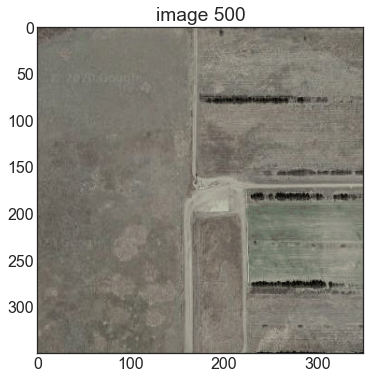

Pulling image 503, total API requests so far = 361
satimg_CO__503_Wild Camping_17_37.102043_-105.384856.png
waiting for: 4 seconds
Pulling image 505, total API requests so far = 362
satimg_CO__505_Wild Camping_17_38.064366_-107.667477.png
waiting for: 5 seconds
Pulling image 506, total API requests so far = 363
satimg_CO__506_Wild Camping_17_39.399604_-108.812415.png
waiting for: 1 seconds
Pulling image 507, total API requests so far = 364
satimg_CO__507_Wild Camping_17_37.37492_-106.965934.png
waiting for: 1 seconds
Pulling image 508, total API requests so far = 365
satimg_CO__508_Wild Camping_17_38.767902_-106.765822.png
waiting for: 2 seconds
Pulling image 509, total API requests so far = 366
satimg_CO__509_Wild Camping_17_38.17458_-105.15155.png
waiting for: 5 seconds
Pulling image 510, total API requests so far = 367
satimg_CO__510_Wild Camping_17_39.439804_-106.397395.png
waiting for: 5 seconds
Pulling image 512, total API requests so far = 368
satimg_CO__512_Wild Camping_17_38.8

waiting for: 3 seconds
Pulling image 138, total API requests so far = 423
satimg_CO__138_Informal Campsite_17_39.582525_-105.360861.png
waiting for: 2 seconds
Pulling image 139, total API requests so far = 424
satimg_CO__139_Informal Campsite_17_38.49984_-106.23237.png
waiting for: 2 seconds
Pulling image 144, total API requests so far = 425
satimg_CO__144_Informal Campsite_17_39.695973_-104.832612.png
waiting for: 3 seconds
Pulling image 148, total API requests so far = 426
satimg_CO__148_Informal Campsite_17_39.737853_-104.527413.png
waiting for: 1 seconds
Pulling image 157, total API requests so far = 427
satimg_CO__157_Informal Campsite_17_39.59194_-104.861127.png
waiting for: 3 seconds
Pulling image 158, total API requests so far = 428
satimg_CO__158_Informal Campsite_17_39.179792_-109.021499.png
waiting for: 1 seconds
Pulling image 161, total API requests so far = 429
satimg_CO__161_Informal Campsite_17_37.954387_-107.828845.png
waiting for: 4 seconds
Pulling image 166, total API

waiting for: 5 seconds
Pulling image 490, total API requests so far = 484
satimg_CO__490_Informal Campsite_17_38.524514_-106.021702.png
waiting for: 2 seconds
Pulling image 494, total API requests so far = 485
satimg_CO__494_Informal Campsite_17_37.998948_-103.593968.png
waiting for: 3 seconds
Pulling image 499, total API requests so far = 486
satimg_CO__499_Informal Campsite_17_38.50578_-106.951536.png
waiting for: 3 seconds
Pulling image 501, total API requests so far = 487
satimg_CO__501_Informal Campsite_17_38.093897_-103.054223.png
waiting for: 4 seconds
Pulling image 502, total API requests so far = 488
satimg_CO__502_Informal Campsite_17_37.26902000000001_-106.99716.png
waiting for: 2 seconds
Pulling image 504, total API requests so far = 489
satimg_CO__504_Informal Campsite_17_37.361218_-108.07808.png
waiting for: 2 seconds
Pulling image 511, total API requests so far = 490
satimg_CO__511_Informal Campsite_17_37.169603_-105.517145.png
waiting for: 1 seconds
Pulling image 513, t

waiting for: 5 seconds
Pulling image 383, total API requests so far = 548
satimg_CO__383_Eco-Friendly_17_38.82507_-106.13977.png
waiting for: 2 seconds
Pulling image 395, total API requests so far = 549
satimg_CO__395_Eco-Friendly_17_39.387498_-107.083325.png
waiting for: 4 seconds


In [25]:
for category in categories:
    print(category)
    tempdf = USdata_CO[USdata_CO['Category'] == category]
    #tempdf.info()
    download_images(gmaps, tempdf, max_requests=max_requests, zoomlevel=17, prefix="CO", out_path=f"data/sites_CO/{category}/")

In [28]:
USdata_CA = USdata_cleaned[USdata_cleaned['State'] == 'CA'].copy()
USdata_AZ = USdata_cleaned[USdata_cleaned['State'] == 'AZ'].copy()
USdata_OR = USdata_cleaned[USdata_cleaned['State'] == 'OR'].copy()
USdata_UT = USdata_cleaned[USdata_cleaned['State'] == 'UT'].copy()
USdata_WA = USdata_cleaned[USdata_cleaned['State'] == 'WA'].copy()
# maybe TX, AK, NM

In [30]:
state_dfs = [USdata_CA, USdata_AZ, USdata_OR, USdata_UT, USdata_WA]
names = ['CA', 'AZ', 'OR', 'UT', 'WA']

In [33]:
max_requests = 10_000

In [ ]:
for name, state in zip(names, state_dfs):
    for category in categories:
        print(category)
        tempdf = state[state['Category'] == category]
        #tempdf.info()
        print(name)
        download_images(gmaps, tempdf, max_requests=max_requests, zoomlevel=17, prefix=f'{name}', out_path=f"data/sites_{name}/{category}/")

Wild Camping
CA
Pulling image 10, total API requests so far = 550
satimg_CA_10_Wild Camping_17_37.812104_-119.906083.png
waiting for: 3 seconds
Pulling image 31, total API requests so far = 551
satimg_CA_31_Wild Camping_17_36.303437_-119.292827.png
waiting for: 2 seconds
Pulling image 33, total API requests so far = 552
satimg_CA_33_Wild Camping_17_34.742828_-120.043322.png
waiting for: 1 seconds
Pulling image 41, total API requests so far = 553
satimg_CA_41_Wild Camping_17_41.505537_-123.996652.png
waiting for: 5 seconds
Pulling image 63, total API requests so far = 554
satimg_CA_63_Wild Camping_17_40.341873_-121.437745.png
waiting for: 2 seconds
Pulling image 69, total API requests so far = 555
satimg_CA_69_Wild Camping_17_37.432003_-117.948857.png
waiting for: 4 seconds
Pulling image 73, total API requests so far = 556
satimg_CA_73_Wild Camping_17_34.501828_-119.730836.png
waiting for: 3 seconds
Pulling image 99, total API requests so far = 557
satimg_CA_99_Wild Camping_17_33.129528

waiting for: 5 seconds
Pulling image 609, total API requests so far = 613
satimg_CA_609_Wild Camping_17_36.732441_-119.472598.png
waiting for: 2 seconds
Pulling image 617, total API requests so far = 614
satimg_CA_617_Wild Camping_17_32.78907_-117.15924.png
waiting for: 2 seconds
Pulling image 629, total API requests so far = 615
satimg_CA_629_Wild Camping_17_35.130857_-118.457271.png
waiting for: 5 seconds
Pulling image 637, total API requests so far = 616
satimg_CA_637_Wild Camping_17_36.137663_-120.276883.png
waiting for: 3 seconds
Pulling image 660, total API requests so far = 617
satimg_CA_660_Wild Camping_17_34.174014_-118.28328799999998.png
waiting for: 1 seconds
Pulling image 668, total API requests so far = 618
satimg_CA_668_Wild Camping_17_35.37154_-120.68389.png
waiting for: 1 seconds
Pulling image 669, total API requests so far = 619
satimg_CA_669_Wild Camping_17_40.181156_-123.779912.png
waiting for: 3 seconds
Pulling image 696, total API requests so far = 620
satimg_CA_69